# Japan Deflation Analysis

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# visualization
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set(color_codes=True)

In [2]:
def transform_dataset(data):
    data = data.set_index('Unnamed: 0')
    data.index.rename('', inplace=True)
    return data

In [3]:
# import relevant dataset
full_data = pd.read_csv('data/full_data.csv')
economic_index = pd.read_csv('data/ei_combined.csv')
cpi_index = pd.read_csv('data/cpi_index.csv')
gdp_production_index = pd.read_csv('data/gdp_production_index.csv')
health_index = pd.read_csv('data/health_index.csv')
population_index = pd.read_csv('data/population_index.csv')
ppp_index = pd.read_csv('data/ppp_index.csv')
productivity_ulc_index = pd.read_csv('data/productivity_ulc_index.csv')

# transform relevant dataset
full_data = transform_dataset(full_data)
economic_index = transform_dataset(economic_index)
cpi_index = transform_dataset(cpi_index)
gdp_production_index = transform_dataset(gdp_production_index)
health_index = transform_dataset(health_index)
population_index = transform_dataset(population_index)
ppp_index = transform_dataset(ppp_index)
productivity_ulc_index = transform_dataset(productivity_ulc_index)

population_index = population_index.drop(columns=['89'])

## Introduction

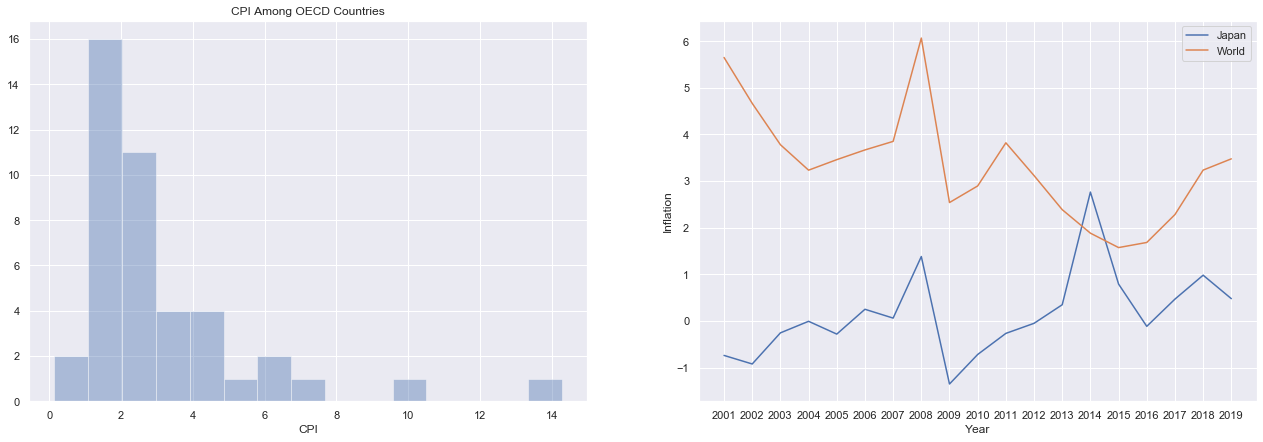

In [4]:
# import data
cpi_history = pd.read_csv('data/cpi.csv')
oecd_cpi = cpi_index['CPI: 01-12 - All items']

# select data
cpi_history = cpi_history.loc[cpi_history['Subject'] == 'CPI: 01-12 - All items'][['Country', 'Time', 'Value']]
cpi_japan = cpi_history.loc[cpi_history['Country'] == 'Japan']
cpi_world = cpi_history.loc[cpi_history['Country'] != 'Japan']

# create data
time_series = cpi_world['Time'].unique()
avg_cpi = []

for time in time_series:
    avg_cpi.append(cpi_world.loc[cpi_world['Time'] == time]['Value'].mean())
    
# plot graph
plt.figure(figsize = (22, 7))

plt.subplot(1, 2, 1)
sns.distplot(oecd_cpi.values, kde=False)
plt.xlabel('CPI')
plt.title('CPI Among OECD Countries')

plt.subplot(1, 2, 2)
plt.plot(cpi_japan['Time'], cpi_japan['Value'], label="Japan")
plt.plot(cpi_japan['Time'], avg_cpi, label="World")
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

## Comparing Social Factors

In [5]:
country_list = cpi_index.index
cpi = cpi_index['CPI: 01-12 - All items'].values
cpi_dict = list(zip(country_list, cpi))

cpi_good = []
for cpi in cpi_dict:
    if cpi[1] >= 2 and cpi[1] <= 3:
        cpi_good.append(cpi)
        
cpi_series = pd.DataFrame({'CPI': [cpi[1] for cpi in cpi_good]}, index=[cpi[0] for cpi in cpi_good])
cpi_series = cpi_series.sort_values(by=['CPI'], ascending=False)
cpi_series

,CPI
Slovenia,2.759940
Australia,2.544193
Lithuania,2.508400
Korea,2.426587
China (People's Republic of),2.326316
Czech Republic,2.156178
Poland,2.154386
United States,2.106992
New Zealand,2.103123
United Kingdom,2.057895


In [6]:
def get_inflation_countries(data):
    relevant_data =  data.loc[
        (data.index == 'Slovenia') |
        (data.index == 'Australia') |
        (data.index == 'Lithuania')|
        (data.index == 'Korea') |
        (data.index == 'China (People\'s Republic of)') |
        (data.index == 'Czech Republic') |
        (data.index == 'Poland') |
        (data.index == 'United States') |
        (data.index == 'New Zealand') |
        (data.index == 'United Kingdom') |
        (data.index == 'Norway') |
        (data.index == 'Spain') |
        (data.index == 'Japan')
    ]
    
    return relevant_data.sort_index()

In [9]:
ei_inflation = get_inflation_countries(economic_index.dropna(axis='columns'))
cpi_inflation = get_inflation_countries(cpi_index.dropna(axis='columns'))
gdp_production_inflation = get_inflation_countries(gdp_production_index.dropna(axis='columns'))
health_inflation = get_inflation_countries(health_index.dropna(axis='columns'))
population_inflation = get_inflation_countries(population_index.dropna(axis='columns'))
ppp_inflation = get_inflation_countries(ppp_index.dropna(axis='columns'))
productivity_inflation = get_inflation_countries(productivity_ulc_index.dropna(axis='columns'))

In [11]:
def create_standarized_dataset(data):
    """
    """
    # create pipeline
    data_copy = data.copy()
    
    if len(data.columns) > 1:
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="mean")),
            ('std_scaler', StandardScaler())
        ])
        transformed_data = num_pipeline.fit_transform(data_copy)
    else:
        transformed_data = StandardScaler().fit_transform(data)
    
    data_copy[:] = transformed_data
    return data_copy

In [39]:
# exclude purchasing power parity, cpi, and health as only one column
ei_standarized = create_standarized_dataset(ei_inflation)
gdp_production_standarized = create_standarized_dataset(gdp_production_inflation)
population_standarized = create_standarized_dataset(population_inflation)
productivity_standarized = create_standarized_dataset(productivity_inflation)
health_standarized = create_standarized_dataset(health_inflation)
ppp_standarized = create_standarized_dataset(ppp_inflation)

In [40]:
pca = PCA(n_components=2)

ei_reduced = pca.fit_transform(ei_standarized)
gdp_production_reduced = pca.fit_transform(gdp_production_standarized)
population_reduced = pca.fit_transform(population_inflation)
productivity_reduced = pca.fit_transform(productivity_standarized)

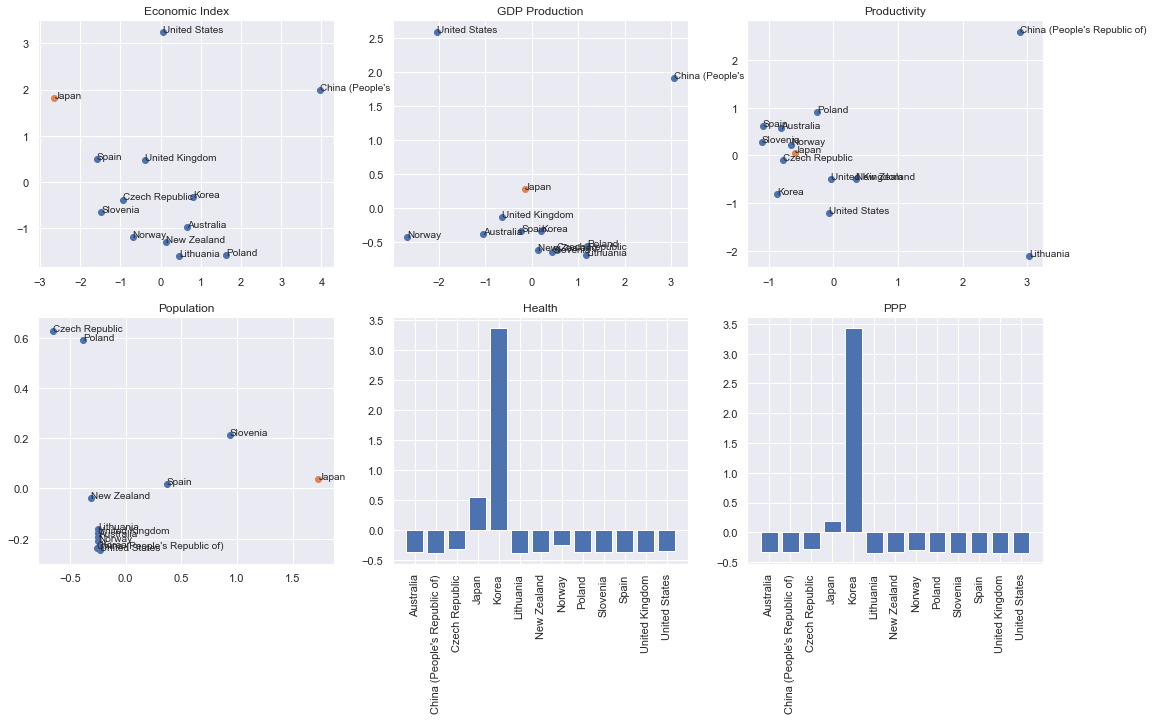

In [44]:
plt.figure(figsize=(18, 10))

index = 1
reduced_data = [("Economic Index", ei_reduced), ("GDP Production", gdp_production_reduced), 
                ("Productivity", productivity_reduced), ("Population", population_reduced), ("Health", health_standarized),
               ("PPP", ppp_standarized)]

for title, data in reduced_data:
    plt.subplot(2, 3, index)
    
    if isinstance(data, pd.DataFrame):
        plt.title(title)
        plt.xticks(rotation=90)
        plt.bar([x for x in data.index], np.ndarray.flatten(data.values))
    else:
        japan = data[3]
        others = np.delete(data, 3, 0)

        plt.scatter(others[:, 0], others[:, 1])
        plt.scatter(japan[0], japan[1])

        country_data = [x for x in ei_inflation.index if x != 'Japan']
        for i, txt in enumerate(country_data):
            plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
        plt.annotate("Japan", (japan[0], japan[1]))
        plt.title(title)
    
    index += 1
plt.show()